### LSTM model

In addition to the methods such as ARIMA and XGBoost mentioned earlier, we also want to try prediction using deep learning. Since this is a time series data, we chose to use LSTM as the model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Use HOBBIES_1_001_CA_1, which is the first item in the HOBBIES_1 category, from the first store in California as partial data. Use this partial data to for model training and compare the results with ARIMA, XGBoost, and LSTM to select the best-performing model.

In [ ]:
CA_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/SL Data/data_by_state/CA_df.csv",\
                      dtype = {'item_id':'str', 'dept_id':'str', 'store_id':'str', 'month':'str', 'year':'str', 'snap':'str'})
CA_data.shape

(23330948, 12)

In [ ]:
CA_data.head()

,item_id,dept_id,cat_id,store_id,state_id,num_sold,weekday,month,year,snap,sell_price,d_num
0,001,1,HOBBIES,1,CA,0,Saturday,1,2011,0,9.58,1
1,001,1,HOBBIES,1,CA,0,Sunday,1,2011,0,9.58,2
2,001,1,HOBBIES,1,CA,0,Monday,1,2011,0,9.58,3
3,001,1,HOBBIES,1,CA,0,Tuesday,2,2011,1,9.58,4
4,001,1,HOBBIES,1,CA,0,Wednesday,2,2011,1,9.58,5


In [ ]:
# Data preprocessing
# Drop year, create id_column
CA_data.drop('year', axis=1, inplace = True)
CA_data['id'] = CA_data['cat_id'] + '_' + CA_data['dept_id'] + '_' + CA_data['item_id'] + '_' + CA_data['state_id'] + '_' + CA_data['store_id']

In [ ]:
# Use store_1 in CA and HOBBIES_1_001
CA_1_data = CA_data[(CA_data['store_id']=='1') & (CA_data['cat_id']=="HOBBIES") & (CA_data['dept_id'] == '1') & (CA_data['item_id'] == '001')]

In [ ]:
# item_1 = CA_1_data
item_1 = CA_1_data.reset_index(drop = True)
item_1.shape

(1913, 12)

#### ONE_HOT_ENCODING
We transformed categorical data using one-hot-encoing. The categorical data includes item id, item dept_id, item cat_id, weekday, and snap.

In [ ]:
item_1_dummy = pd.get_dummies(item_1,columns = ['item_id', 'dept_id', 'cat_id', 'weekday', 'snap'], drop_first=True)
item_1_dummy.head(2)

,store_id,state_id,num_sold,month,sell_price,d_num,id,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,snap_1
0,1,CA,0,1,9.58,1,HOBBIES_1_001_CA_1,0,1,0,0,0,0,0
1,1,CA,0,1,9.58,2,HOBBIES_1_001_CA_1,0,0,1,0,0,0,0


In [ ]:
# Take 10% of data to be the model's validation data
train_1_data, val_1_data = item_1_dummy[item_1_dummy['d_num'] < 1723], item_1_dummy[item_1_dummy['d_num'] >= 1723]

#### Create train test dataframes

In [ ]:
def create_xy_data(df):
  x_train_id, y_train = df['id'],df['num_sold']
  df = df.drop(['id','d_num','state_id','num_sold','store_id'],axis=1)
  return df, y_train, x_train_id

In [ ]:
x_train, y_train, x_train_id = create_xy_data(train_1_data)
x_val, y_val, x_val_id = create_xy_data(val_1_data)

In [ ]:
x_train.head()

,month,sell_price,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,snap_1
0,1,9.58,0,1,0,0,0,0,0
1,1,9.58,0,0,1,0,0,0,0
2,1,9.58,1,0,0,0,0,0,0
3,2,9.58,0,0,0,0,1,0,1
4,2,9.58,0,0,0,0,0,1,1


In [ ]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: num_sold, dtype: int64

#### Standardize continuous variables
Standardizing continuous variables can reduce biases in weights caused by differences in numerical scales. In our case, the only continuous variable is price, so we only need to standardize the price feature.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_x = StandardScaler()
x_train['sell_price'] = scaler_x.fit_transform(np.array(x_train['sell_price']).reshape(-1,1))
x_val['sell_price'] = scaler_x.transform(np.array(x_val['sell_price']).reshape(-1,1))

In [ ]:
x_train.head(2)

,month,sell_price,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,snap_1
0,1,0.94462,0,1,0,0,0,0,0
1,1,0.94462,0,0,1,0,0,0,0


In [ ]:
print(x_train.shape, x_val.shape)

(1722, 9) (191, 9)


### Convert Data Dimension
LSTM是適合時間序列的模型，也因為這個特性，input data 可以是三維的資料，也就是除了平常的(資料筆數, 特徵數量)以外，還可以加上時間。

由於這次的目標是預測未來28天，因此我們很初步的將往回看的資料設定為前28天，也就是說每個資料點在做判斷時，模型會同時考量前28天的資料。加入時間後，特徵dataframe的維度會變為(資料筆數, 往回看的天數, 特徵數量)的三維資料。

LSTM is a model suitable for time series data, and due to this characteristic, the input data can be three-dimensional. Besides the usual dimensions (number of data points, number of features), we can also include a time dimension.

Since our goal is to predict the next 28 days, we initially set the lookback period to the previous 28 days. This means that when making predictions for each data point, the model will simultaneously consider the data from the past 28 days. After adding the time data, the dimensions of the feature dataframe become three-dimensional (number of data points, lookback days, number of features).

In [ ]:
LOOKBACK_MAX = 28

In [ ]:
x_train_time = []
for i in range(LOOKBACK_MAX, x_train.shape[0]):
  x_train_time.append(x_train.iloc[i - LOOKBACK_MAX:i].values.tolist())
x_train_time = np.array(x_train_time)

x_val_time = []
for i in range(LOOKBACK_MAX, x_val.shape[0]):
  x_val_time.append(x_val.iloc[i-LOOKBACK_MAX:i].values.tolist())
x_val_time = np.array(x_val_time)

y_train = y_train.values
y_val = y_val.values
y_train_time = y_train[LOOKBACK_MAX:]
y_val_time = y_val[LOOKBACK_MAX:]
print(x_train_time.shape, y_train_time.shape, x_val_time.shape, y_val_time.shape)

(1694, 28, 9) (1694,) (163, 28, 9) (163,)


#### Build Model
We use Keras as the tool to build the model. The model consists of one LSTM layer followed by three Dense layers. The activation function for the last Dense layer is set to linear because we are dealing with a regression problem where we aim to predict continuous values.

In [ ]:
import keras
from keras import Sequential
from keras import layers

In [ ]:
def build_model(shape):
  model = Sequential()
  model.add(layers.LSTM(50, input_shape=(shape[1], shape[2]), return_sequences=False))

  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1, activation = 'linear'))

  model.compile(
      loss= keras.losses.MeanSquaredError(),
      optimizer='adam',
  )

  return model

In [ ]:
model = build_model(x_train_time.shape)
history = model.fit(x = x_train_time,
                    y = y_train_time,
                    epochs=10,
                    validation_data=(x_val_time, y_val_time),
                    shuffle=True,
                    batch_size=128)

Train on 1694 samples, validate on 163 samples
Epoch 1/10
1694/1694 [==============================] - 1s 592us/step - loss: 0.3584 - val_loss: 1.3170
Epoch 2/10
1694/1694 [==============================] - 1s 378us/step - loss: 0.3074 - val_loss: 1.2073
Epoch 3/10
1694/1694 [==============================] - 1s 356us/step - loss: 0.3027 - val_loss: 1.3468
Epoch 4/10
1694/1694 [==============================] - 1s 361us/step - loss: 0.3047 - val_loss: 1.2506
Epoch 5/10
1694/1694 [==============================] - 1s 359us/step - loss: 0.3012 - val_loss: 1.2629
Epoch 6/10
1694/1694 [==============================] - 1s 364us/step - loss: 0.2971 - val_loss: 1.2647
Epoch 7/10
1694/1694 [==============================] - 1s 360us/step - loss: 0.2970 - val_loss: 1.2930
Epoch 8/10
1694/1694 [==============================] - 1s 357us/step - loss: 0.2953 - val_loss: 1.2366
Epoch 9/10
1694/1694 [==============================] - 1s 365us/step - loss: 0.2951 - val_loss: 1.2798
Epoch 10/10
1694/

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50)                12000     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 14,177
Trainable params: 14,177
Non-trainable params: 0
_________________________________________________________________


#### Validation Prediction Results
We use the previously prepared validation data to validate the model. We look at the RMSE and how the predicted values compare to the actual values in terms of their graphical representation.

In [ ]:
y_pre_val = model.predict(x_val_time)
y_pre_val = y_pre_val.reshape(-1,)

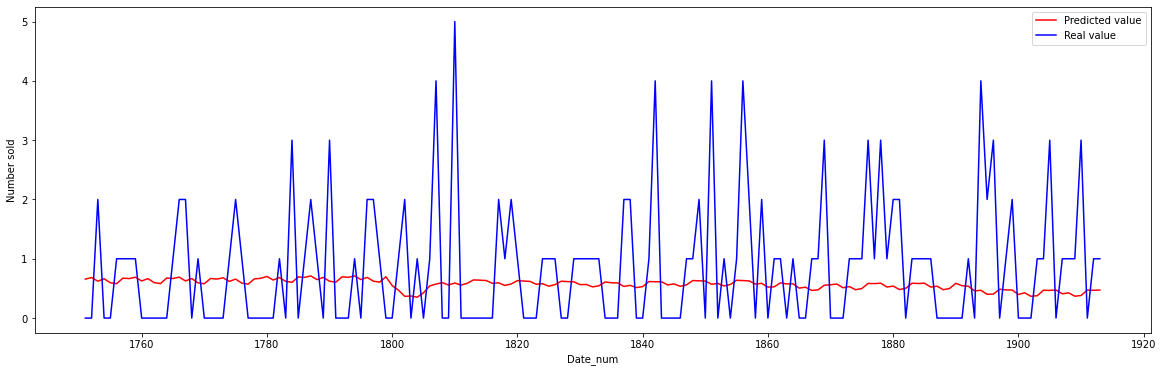

In [ ]:
plt_x = np.arange(1914-len(y_val_time), 1914, 1)
plt_y1 = y_pre_val
plt_y2 = y_val_time
plt.figure(figsize=(20,6))
plt.plot(plt_x, plt_y1, color='r', label = "Predicted value")
plt.plot(plt_x, plt_y2, color = 'b', label = "Real value")
plt.legend()
plt.xlabel("Date_num")
plt.ylabel("Number sold")
plt.show()
plt.close()

In [ ]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_pre_val, y_val_time))
print("RMSE = ", RMSE)

RMSE =  1.1165011935545595


### Another DL Model

In [ ]:
def build_CNN(shape):
  model = Sequential()
  model.add(layers.Conv1D(32, kernel_size=4,input_shape = (shape[1], shape[2],),activation="relu"))
  model.add(layers.MaxPooling1D())
  model.add(layers.Conv1D(32, kernel_size=4,activation="relu"))
  model.add(layers.MaxPooling1D())
  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))

  opt = keras.optimizers.Adam()
  model.compile(
      loss='MSE',
      optimizer=opt
  )

  return model

In [ ]:
CNN_model = build_CNN(x_train_time.shape)
history = CNN_model.fit(x = x_train_time,
                        y = y_train_time,
                        epochs=10,
                        validation_data=(x_val_time, y_val_time),
                        shuffle=True,
                        batch_size = 128)

Train on 1694 samples, validate on 163 samples
Epoch 1/10
1694/1694 [==============================] - 0s 292us/step - loss: 0.3425 - val_loss: 1.2831
Epoch 2/10
1694/1694 [==============================] - 0s 194us/step - loss: 0.3034 - val_loss: 1.2380
Epoch 3/10
1694/1694 [==============================] - 0s 193us/step - loss: 0.2974 - val_loss: 1.3303
Epoch 4/10
1694/1694 [==============================] - 0s 192us/step - loss: 0.2968 - val_loss: 1.2529
Epoch 5/10
1694/1694 [==============================] - 0s 191us/step - loss: 0.2900 - val_loss: 1.2538
Epoch 6/10
1694/1694 [==============================] - 0s 190us/step - loss: 0.2867 - val_loss: 1.2324
Epoch 7/10
1694/1694 [==============================] - 0s 193us/step - loss: 0.2853 - val_loss: 1.2539
Epoch 8/10
1694/1694 [==============================] - 0s 194us/step - loss: 0.2872 - val_loss: 1.2011
Epoch 9/10
1694/1694 [==============================] - 0s 191us/step - loss: 0.2897 - val_loss: 1.1959
Epoch 10/10
1694/

In [ ]:
y_pre_val = CNN_model.predict(x_val_time)
y_pre_val = y_pre_val.reshape(-1,)

In [ ]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_pre_val, y_val_time))
print("RMSE = ", RMSE)

RMSE =  1.1066745379814134
